In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split


In [2]:
# Data Loading
reg_df=pd.read_csv("Regression_data.csv")
arima_df=pd.read_csv("Arima_data.csv").set_index("Date ")
arima_df.index = pd.to_datetime(arima_df.index)

In [3]:
reg_df.head()

,Date,High_Stationary,HIGH,lag_1,lag_2
0,2000-06-01,-25.35,354.65,26.95,6.00
1,2000-07-01,20.90,377.70,-25.35,26.95
2,2000-08-01,-8.65,346.00,20.90,-25.35
3,2000-09-01,12.10,389.80,-8.65,20.90
4,2000-10-01,2.50,348.50,12.10,-8.65


In [4]:
arima_df.head()

,High_Stationary,HIGH
Date,,
2000-04-01,6.00,380.00
2000-05-01,26.95,356.80
2000-06-01,-25.35,354.65
2000-07-01,20.90,377.70
2000-08-01,-8.65,346.00


In [5]:
arima_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 273 entries, 2000-04-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   High_Stationary  273 non-null    float64
 1   HIGH             273 non-null    float64
dtypes: float64(2)
memory usage: 6.4 KB


Arima Model


In [6]:

def get_scores(original,predicted,model_name):
    
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(original, predicted))
    mae = mean_absolute_error(original, predicted)
    r2 = r2_score(original,predicted)
    model_scores[str(model_name)] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    return model_scores

In [7]:
 from statsmodels.tsa.arima.model import ARIMA

# 1,0,2 ARIMA Model
model = ARIMA(arima_df['HIGH '], order=(1,0,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  HIGH    No. Observations:                  273
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1748.708
Date:                Fri, 21 Apr 2023   AIC                           3507.417
Time:                        13:00:37   BIC                           3525.464
Sample:                    04-01-2000   HQIC                          3514.661
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1212.7472    589.772      2.056      0.040      56.816    2368.679
ar.L1          0.9816      0.015     63.335      0.000       0.951       1.012
ma.L1          0.1476      0.054      2.741      0.0

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# 0,1,2 ARIMA Model
model = ARIMA(arima_df['HIGH '], order=(0,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  HIGH    No. Observations:                  273
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1741.485
Date:                Fri, 21 Apr 2023   AIC                           3488.970
Time:                        13:00:37   BIC                           3499.787
Sample:                    04-01-2000   HQIC                          3493.312
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1345      0.043      3.109      0.002       0.050       0.219
ma.L2         -0.0849      0.053     -1.598      0.110      -0.189       0.019
sigma2      2.131e+04    596.392     35.735      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05)**

*Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).*

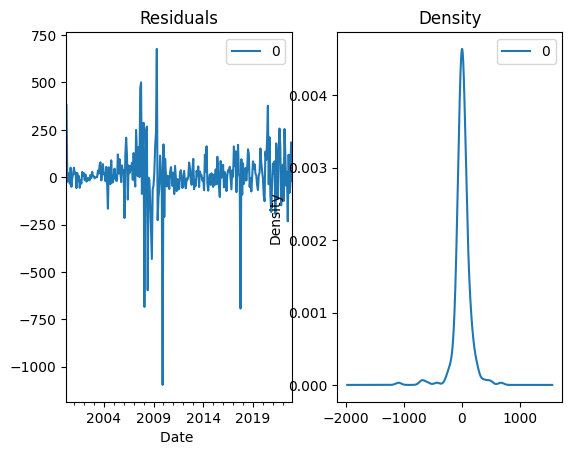

In [9]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

*The residual errors seem fine with near zero mean and uniform variance.*

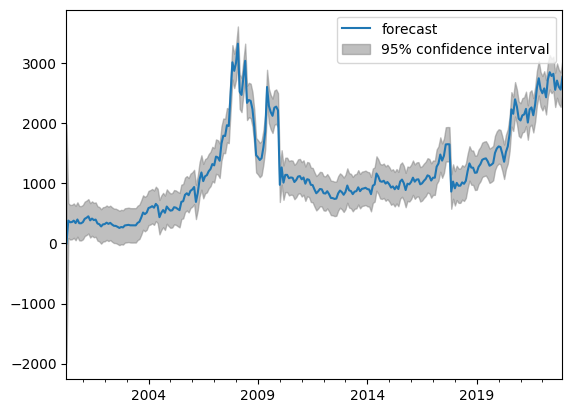

In [10]:
# Actual vs Fitted
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model_fit,dynamic=False,alpha=0.05)
plt.show()

In [11]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = arima_df['HIGH '][:-12]
test = arima_df['HIGH '][-12:]

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


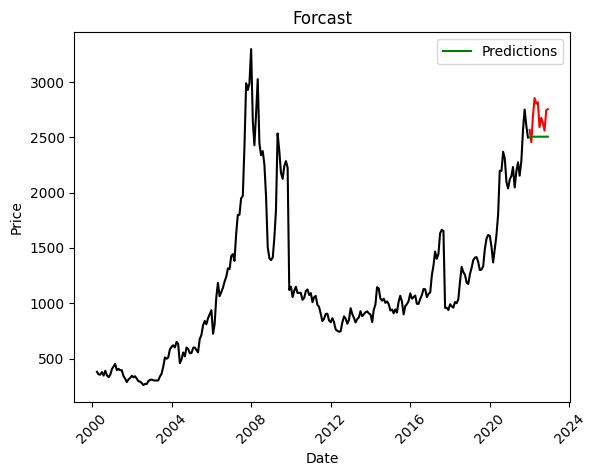

In [12]:
model = ARIMA(train, order=(0, 1, 2))  
fitted = model.fit() 

y_pred = fitted.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = fitted.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Forcast")


plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

In [13]:
ar=get_scores(test,y_pred_out,"ARIMA")

RMSE: 208.86695272858614
MAE: 181.94144615204695
R2 Score: -2.2163342267185007


In [16]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.2 MB/s eta 0:00:00


In [17]:
import pmdarima as pm
model = pm.auto_arima(arima_df["HIGH "], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3491.014, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3493.325, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3491.406, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3490.352, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3492.274, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3490.091, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3491.957, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3491.838, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3490.149, Time=1.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3488.970, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3489.076, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3490.862, Time=0.51 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3490.765, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3489.790, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0]          

In [18]:
smodel = pm.auto_arima(arima_df["HIGH "], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.02 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3979.849, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3449.051, Time=1.02 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=3727.978, Time=1.96 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3989.678, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3510.909, Time=0.41 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3428.431, Time=7.22 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=14.07 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.44 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=3983.627, Time=3.10 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=3423.612, Time=16.37 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=3443.323, Time=6.00 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=22.58 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.06 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  273
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood               -1705.609
Date:                             Fri, 21 Apr 2023   AIC                           3421.217
Time:                                     13:04:29   BIC                           3439.040
Sample:                                 04-01-2000   HQIC                          3428.381
                                      - 12-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9490      0.017     57.269      0.000       0.917       0.981
ma.L1          0.1948      0.067      2.924      0.003       0.064       0.325
ar.S.L12      -0.6250      0.041    -15.345      0.000      -0.705      -0.545
ar.S.L24      -0.2956      0.044     -6.771      0.000      -0.381      -0.210
sigma2       2.71e+04   1080.697     25.079      0.000     2.5e+04    2.92e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1086.27
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -1.47
Prob(H) (two-sided):                  0.78   Kurtosis:                        12.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/

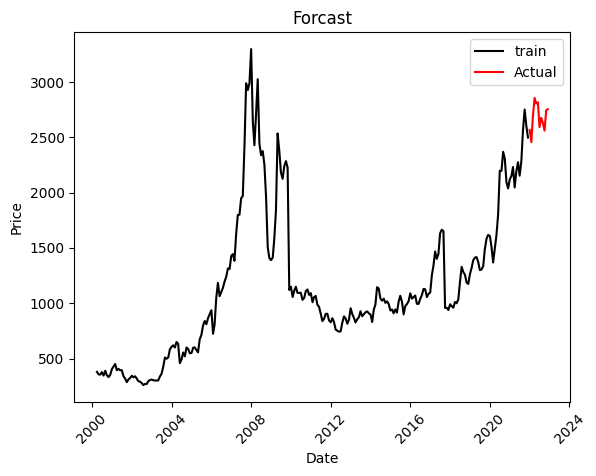

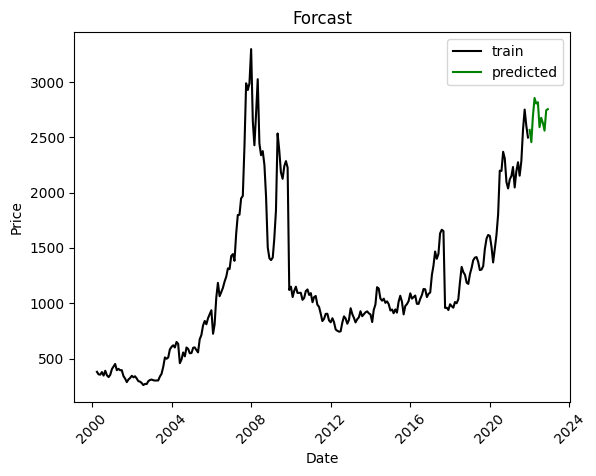

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
SARIMAXmodel = SARIMAX(test, order = (1, 0, 1), seasonal_order=(2,1,0,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black",label = 'train')
plt.plot(test, color = "red", label = 'Actual')
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Forcast")
plt.legend()
plt.show()

plt.plot(train, color = "black",label = 'train')
plt.plot(y_pred_out, color = "green", label = 'predicted')
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Forcast")
plt.legend()
plt.show()

In [20]:
sx=get_scores(test,y_pred_out,"SARIMAx")

RMSE: 2.6254850544756925e-13
MAE: 1.5158245029548803e-13
R2 Score: 1.0


In [21]:

merge={**ar,**sx}
print(merge)

{'ARIMA': [208.86695272858614, 181.94144615204695, -2.2163342267185007], 'SARIMAx': [2.6254850544756925e-13, 1.5158245029548803e-13, 1.0]}


In [24]:
model_scores_df=pd.DataFrame(merge,index=["RMSE","MAE","R2_SCORE"])
model_scores_df[:2].T

,RMSE,MAE
ARIMA,2.088670e+02,1.819414e+02
SARIMAx,2.625485e-13,1.515825e-13


<Axes: >

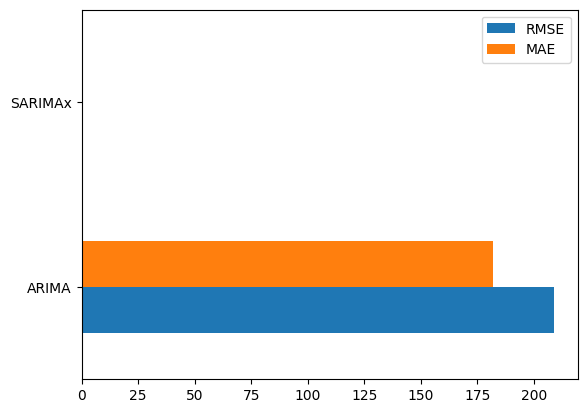

In [25]:
model_scores_df[:2].T.plot(kind="barh")